In [1]:
from models.unet.unet import *
from models.unet.unet_attention import *

from datahandler import DataHandler
import glob

from keras import models

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import math
import cv2

import random

%matplotlib inline
plt.gray()


Using TensorFlow backend.


<Figure size 432x288 with 0 Axes>

In [2]:
def getGrid(act_i, images_per_row = 8, n_cols = 1):
    
    layer_activation = activations[act_i]
    n_features = layer_activation.shape[-1]# Number of features in the feature map
    
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    #n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            r = random.randint(0, n_features - 1)
            channel_image = layer_activation[0,:, :,r]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

    return display_grid


In [3]:
def plotSubplot(grid, name, g_shape, pos, rspan, cspan, no_cmap=False):
    ax = plt.subplot2grid(grid_shape, pos, rowspan=rspan, colspan=cspan)
    ax.set_title(name)
    if no_cmap:
        ax.imshow(grid, aspect='auto')
    else:
        ax.imshow(grid, aspect='auto', cmap='viridis')
    plt.xticks([])
    plt.yticks([])
    

In [4]:
classifier = getUnet()
layer_outputs = [layer.output for layer in classifier.layers[1:]] # Extracts the outputs of all
activation_model = models.Model(inputs=classifier.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
activation_model.load_weights('./logs/unet/kfold_unet/kfold_unet_dice_DA_K9/kfold_unet_dice_DA_K9_weights.h5')

W0814 09:52:15.875723 4432442816 deprecation_wrapper.py:119] From /Users/alejandrovaldes/AnacondaProjects/fetal-brain-segmentation/models/unet/unet.py:16: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0814 09:52:15.878762 4432442816 deprecation_wrapper.py:119] From /Users/alejandrovaldes/AnacondaProjects/fetal-brain-segmentation/models/unet/unet.py:17: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0814 09:52:15.915311 4432442816 deprecation_wrapper.py:119] From /Users/alejandrovaldes/anaconda3/envs/thesis/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0814 09:52:15.925170 4432442816 deprecation_wrapper.py:119] From /Users/alejandrovaldes/anaconda3/envs/thesis/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecate

In [6]:
img_file = 'data/prev/Normal01/fetus_05.nii'
dh = DataHandler()
img, _ = dh.getImageData(img_file)
img_slice = img[33]
img_tensor = np.expand_dims(img_slice, axis=0)

In [7]:
wanted_layers = ['conv2d_2', 'conv2d_4', 'conv2d_6', 'conv2d_13', 'conv2d_8', 'conv2d_19', 'conv2d_16', 'conv2d_22']
indexes = [1, 4, 7, 10, 20, 25, 30, 35]
names = ['down block 1', 'down block 2', 'down block 3', 'down block 4', 'up block 1', 'up block 2', 'up block 3', 'up block 4']

/Users/alejandrovaldes/anaconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


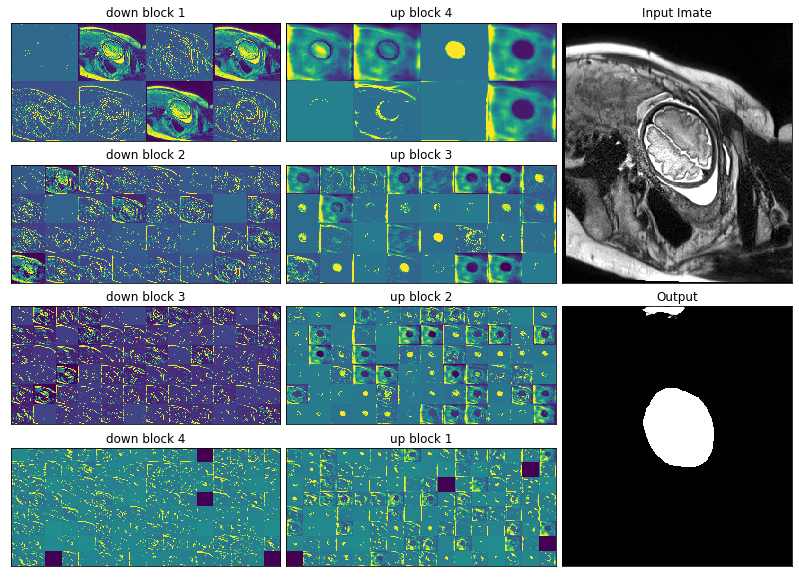

In [8]:
activations = activation_model.predict(img_tensor) 

fig = plt.figure(1)
cols = 20
rows = 4
grid_shape = (rows, cols)
gridspec.GridSpec(rows, cols) 

i_up = -1

for i in range(4):
    n_rows = (i + 1) * 2
    n_imgs = (i + 1) * 4
    rspan = 1
    cspan = 7
    
    grid = getGrid(indexes[i], n_imgs, n_rows)
    plotSubplot(grid, names[i], grid_shape, (i,0), rspan=rspan, cspan=cspan)
    grid = getGrid(indexes[-(i +1)], n_imgs, n_rows)
    plotSubplot(grid, names[-(i + 1)], grid_shape, (i,cspan), rspan=rspan, cspan=cspan)

grid = np.squeeze(img_slice)
plotSubplot(grid, 'Input Imate', grid_shape, (0,14), rspan=2, cspan=8, no_cmap=True)

grid = np.squeeze(activations[-1][0,:,:,0])
plotSubplot(grid, 'Output', grid_shape, (2,14), rspan=2, cspan=8, no_cmap=True)

fig.set_size_inches(w=14,h=10)

In [ ]:
classifier = getAttentionUnet()
layer_outputs = [layer.output for layer in classifier.layers[1:]] # Extracts the outputs of all
activation_model = models.Model(inputs=classifier.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
activation_model.load_weights('./logs/unet_attention/kfold_unet_attention/kfold_unet_attention_dice_DA_K9/kfold_unet_attention_dice_DA_K9_weights.h5')

In [ ]:
wanted_layers = ['conv2d_2', 'conv2d_4', 'conv2d_6', 'conv2d_13', 'conv2d_8', 'conv2d_19', 'conv2d_16', 'conv2d_22']
indexes = [1, 4, 7, 10, 26, 37, 48, 59]
names = ['down block 1', 'down block 2', 'down block 3', 'down block 4', 'up block 1', 'up block 2', 
         'up block 3', 'up block 4']
gates = [23, 34, 45, 56]

In [ ]:
activations = activation_model.predict(img_tensor) 
print(len(activations))

fig = plt.figure(1)
cols = 29
rows = 4
grid_shape = (rows, cols)
gridspec.GridSpec(rows, cols) 

i_up = -1

for i in range(4):
    n_rows = (i + 1) * 2
    n_imgs = (i + 1) * 4
    rspan = 1
    cspan = 7
    
    grid = getGrid(indexes[i], n_imgs, n_rows)
    plotSubplot(grid, names[i], grid_shape, (i,0), rspan=rspan, cspan=cspan)
    
    grid = getGrid(gates[-(i +1)], n_imgs, n_rows)
    plotSubplot(grid, "grid attention gate " + str(i+1), grid_shape, (i, cspan), rspan=rspan, cspan=cspan)
    
    grid = getGrid(indexes[-(i +1)], n_imgs, n_rows)
    plotSubplot(grid, names[-(i + 1)], grid_shape, (i, cspan * 2), rspan=rspan, cspan=cspan)
    

grid = (np.squeeze(img_slice) * 0.75) + (np.squeeze(activations[-1][0,:,:,0] * 255))
plotSubplot(grid, 'Input Image + output', grid_shape, (0,21), rspan=2, cspan=8, no_cmap=True)

grid = getGrid(gates[2], 2, 2)
plotSubplot(grid, 'Zoom on grid attention gate 2', grid_shape, (2,21), rspan=2, cspan=8)

fig.set_size_inches(w=16,h=10)

In [ ]:
classifier = getAttentionUnet()
layer_outputs = [layer.output for layer in classifier.layers[1:]] # Extracts the outputs of all
activation_model = models.Model(inputs=classifier.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
activation_model.load_weights('./logs/unet_attention/kfold_unet_attention/kfold_unet_attention_dice_DA_K9/kfold_unet_attention_dice_DA_K9_weights.h5')